#Вопрос 1
В данном задании вам нужно будет

проанализировать АБ тест, проведенный на реальных пользователях Яндекса
подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
определить характер этих изменений и практическую значимость вводимого изменения
понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)
Описание данных:

userID: уникальный идентификатор пользователя
browser: браузер, который использовал userID
slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
n_clicks: количество кликов, которые пользоваль совершил за n_queries
n_queries: количество запросов, который совершил userID, пользуясь браузером browser
n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика
Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

ab_browser_test.csv
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.


In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools
data=pd.read_csv('Week4/ab_browser_test.csv')
data.head()
exp_cl = data['n_clicks'][data['slot']=='exp'].sum()
control_cl = data['n_clicks'][data['slot']=='control'].sum()
print exp_cl
print control_cl
print ((exp_cl-control_cl)*100/float(control_cl))
print 'Answer1 - %f' % ((exp_cl-control_cl)*100/float(control_cl))
print 'Answer1 - %f' % round((exp_cl-control_cl)*100/float(control_cl),3)

3261823
3210027
1.61356898244
Answer1 - 1.613569
Answer1 - 1.614000


#Вопрос 2
Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

95% доверительный интервал для разности средних содержит ноль, похоже, средние существенно не отличаются

__95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо__

Применение bootstrap на выборках такого большого размера неправомерно, потому что bootstrap делает псведовыборки с возвращениями, а с ростом объема исходной выборки псведовыборки с возвращениями становятся более похожими на псведовыборки без возвращения.

__95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо__

95% доверительный интервал для разности медиан содержит ноль, похоже, медианы существенно не отличаются

In [5]:
def get_bootstrap_samples(data, n_samples):
    for i in np.arange(0, n_samples,1):
        indices = np.random.randint(0, len(data),  len(data))
        samples = data[indices]
        yield samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
exp_arr = data[data['slot']=='exp'].n_clicks.values
control_arr = data[data['slot']=='control'].n_clicks.values

median_score = np.array(map(np.median, get_bootstrap_samples(exp_arr, 500))) - \
               np.array(map(np.median, get_bootstrap_samples(control_arr, 500)))
mean_scores = np.array(map(np.mean, get_bootstrap_samples(exp_arr, 500))) - \
              np.array(map(np.mean, get_bootstrap_samples(control_arr, 500)))

print "95% confidence interval for the  median:",  stat_intervals(median_score, 0.05)
print "95% confidence interval for the mean:",  stat_intervals(mean_scores, 0.05)

95% confidence interval for the  median: [ 1.  1.]
95% confidence interval for the mean: [ 0.20908495  0.40984934]


Ответ:
ТАк как p_value экстремально мало, то мы можем отвергнуть нулевую гипотезу о равенстве средних в пользу двустороннкей альтернативы.

#Вопрос 3
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием в нашей задаче будет z-критерий.

Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал

Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального.

Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения.

__Все ответы неверны__

((array([-4.56803136, -4.37849064, -4.27570691, ...,  4.27570691,
        4.37849064,  4.56803136]), array([  0,   0,   0, ..., 717, 738, 776], dtype=int64)), (14.936694023577203, 11.584000994388802, 0.73871622543583693))


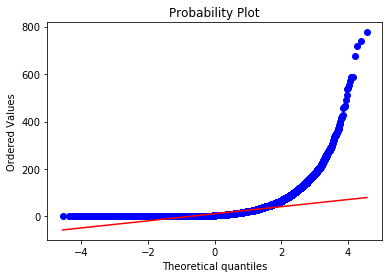

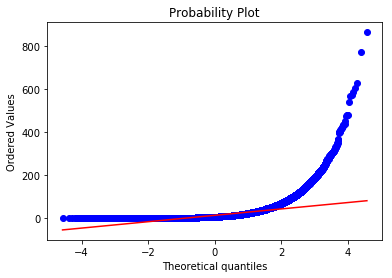

In [13]:
#%pylab inline
import matplotlib.pyplot as plt
#seaborn.regplot(x='day_calls', y='mes_estim', data=data); plt.show()
r=stats.probplot(exp_arr, dist="norm", plot=plt)
print r
plt.show()
stats.probplot(control_arr, dist="norm", plot=plt)
plt.show()

#Вопрос 4
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных.

Для простоты рассмотрим одновыборочный t-критерий. Его статистика имеет вид X¯−μS2/n√, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

X¯ — среднее значение в выборке — было распределено нормально N(μ,σ2n)
nσ2S2 — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)
Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого

Получите из данных n_boot_samples псевдовыборок.
По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения с помощью команды


1
2
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt)
Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:



1
2
np.random.seed(0)
n_boot_samples = 500
В качестве ответа отметьте верные утвердения о значениях R2, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.



Почему мы проверяем именно такие условия?

В исходной постановке t-критерий требует нормальности распределения Xi. Именно из-за этого предположения мы имеем, что ∑iXi∼N(nμ,nσ2) в силу линейности матожидания, независимости всех Xi между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что 1n∑iXi−μ ∼ N(0,σ2n)

Заметим теперь, что следующие распределения эквивалентны N(0,σ2n)∼σ2n−−√N(0,1)
То есть другими словами мы получили, что исходная статистика X¯−μS2/n√ распределена как N(0,1)S2nnσ2√ ∼ N(0,1)S2σ2√
Вспомним, что распределение Стьюдента с n−1 степенями свободы определяется как N(0,1)χ2/(n−1)√. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно Xi были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

__R2 для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99__

__R2 для выборочного среднего получился больше, чем 0.99__

R2 для выборочной суммы квадратов отклонения от выборочной суммы получился меньше, чем 0.99

R2 для выборочного среднего получился меньше, чем 0.99

Populating the interactive namespace from numpy and matplotlib


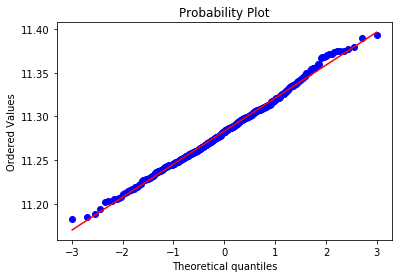

0.995953774208


In [36]:
control_arr = data[data['slot']=='control'].n_clicks.values
np.random.seed(0)
control_mean = np.array(map(np.mean, get_bootstrap_samples(control_arr, 500)))
%pylab inline
mean_res=stats.probplot(control_mean, plot=pylab)
pylab.show()
print mean_res[1][2]**2

Populating the interactive namespace from numpy and matplotlib


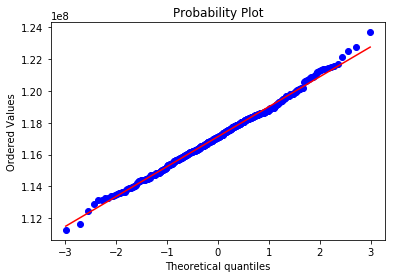

0.996449367709


In [35]:
def sum_sqr_varr(data):
    return np.sum((data - data.mean())**2)

np.random.seed(0)
control_varr = np.array(map(sum_sqr_varr, get_bootstrap_samples(control_arr, 500)))
%pylab inline
varr_res=stats.probplot(control_varr, plot=pylab)
pylab.show()
print varr_res[1][2]**2

#Вопрос 5
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

Критерий Манна-Уитни в данной задаче применять нельзя, поэтому вопрос о достигаемом уровне значимости некорректен

Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками

p<0.01, поэтому можно сказать, что отличия незначительны на уровне доверия 0.05

Согласно полученному значению p-value, мы вынуждены принять нулевую гипотезу

In [46]:
user_control= data[data['slot']=='control'].groupby(['userID'])['n_clicks'].sum()
user_exp= data[data['slot']=='exp'].groupby(['userID'])['n_clicks'].sum()

stats.mannwhitneyu(user_exp, user_control)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [91]:
len(user_exp)

281450

Ответ:
ТАк как p_value экстремально мало, то мы можем отвергнуть нулевую гипотезу о равенстве средних в пользу двустороннкей альтернативы.

In [66]:
#Реализация критерия МаннаУитни
import scipy
from collections import namedtuple
MannwhitneyuResult = namedtuple('MannwhitneyuResult', ('statistic', 'pvalue'))
def tiecorrect(rankvals):
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)
    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)

def mannwhitneyu(x, y, use_continuity=True, alternative=None):
    if alternative is None:
        warnings.warn("Calling `mannwhitneyu` without specifying "
                      "`alternative` is deprecated.", DeprecationWarning)

    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)
    ranked = scipy.stats.rankdata(np.concatenate((x, y)))
    rankx = ranked[0:n1]  # get the x-ranks
    u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
    u2 = n1*n2 - u1  # remainder is U for y
    T = tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in mannwhitneyu')
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)

    meanrank = n1*n2/2.0 + 0.5 * use_continuity
    if alternative is None or alternative == 'two-sided':
        bigu = max(u1, u2)
    elif alternative == 'less':
        bigu = u1
    elif alternative == 'greater':
        bigu = u2
    else:
        raise ValueError("alternative should be None, 'less', 'greater' "
                         "or 'two-sided'")
    z = (bigu - meanrank) / sd
    if alternative is None:
        # This behavior, equal to half the size of the two-sided
        # p-value, is deprecated.
        p = scipy.stats.distributions.norm.sf(abs(z))
    elif alternative == 'two-sided':
        p = 2 * scipy.stats.distributions.norm.sf(abs(z))
    else:
        p = scipy.stats.distributions.norm.sf(z)
    u = u2
    # This behavior is deprecated.
    if alternative is None:
        u = min(u1, u2)
    return MannwhitneyuResult(u, p)
mannwhitneyu(user_exp, user_control)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.


MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

#Вопрос 6
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.


In [76]:
from statsmodels.sandbox.stats.multicomp import multipletests
corr_data = []
for i in data['browser'].unique():
    browser_control=data[(data['slot']=='control') & (data['browser']==i)]['n_clicks']
    browser_exp=    data[(data['slot']=='exp') & (data['browser']==i)]['n_clicks']
    #corr, p= stats.mannwhitneyu(browser_exp, browser_control)
    corr, p= mannwhitneyu(browser_exp, browser_control)
    corr_data.append([i, corr, p])
browser_exp_control = pd.DataFrame.from_records(corr_data)
browser_exp_control.columns = ['browser', 'corr', 'p']  
browser_exp_control.head(10)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.


,browser,corr,p
0,Browser #2,1.522573e+09,0.027244
1,Browser #4,3.072448e+09,0.407606
2,Browser #14,8.069847e+08,0.000000
3,Browser #17,1.313897e+08,0.037401
4,Browser #20,1.437918e+08,0.453667
5,Browser #22,2.547598e+09,0.257406


In [79]:
reject, p_corrected, a1, a2 = multipletests(browser_exp_control.p, 
                                            alpha = 0.05, 
                                            method = 'holm')
browser_exp_control['p_corrected'] = p_corrected
browser_exp_control['reject'] = reject
browser_exp_control.head(10)

,browser,corr,p,p_corrected,reject
0,Browser #2,1.522573e+09,0.027244,0.136219,False
1,Browser #4,3.072448e+09,0.407606,0.815212,False
2,Browser #14,8.069847e+08,0.000000,0.000000,True
3,Browser #17,1.313897e+08,0.037401,0.149602,False
4,Browser #20,1.437918e+08,0.453667,0.815212,False
5,Browser #22,2.547598e+09,0.257406,0.772217,False


In [86]:
print "Answer - 5"

Answer - 5


#Вопрос 7
Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

По всем браузерам мы видим незначительное уменьшение доли некликнутых запросов, поэтому делаем вывод о том, что тестируемое изменение приносит больше вреда, чем пользы.

По одному из браузеров мы видим значительное уменьшение доли некликнутых запросов, поэтому уже только на этом основании тестируемое изменение можно рекомендовать к применению для всех пользователей.

С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.

Тестируемое изменение можно предложить к внедрению только на тот сегмент пользователей, где локализуется изменение, то есть для того браузера, для которого доля некликнутых запросов уменьшилась больше всего. Для прочих браузеров мы не обладаем никакой информацией относительно влияния тестируемого изменения на поведение пользователей.

In [89]:
corr_data = []
for i in data['browser'].unique():
    browser_control_nonclick=data[(data['slot']=='control') & (data['browser']==i)]['n_nonclk_queries'].sum()
    print browser_control_nonclick
    browser_exp_nonclick=    data[(data['slot']=='exp') & (data['browser']==i)]['n_nonclk_queries'].sum()
    print browser_exp_nonclick
    browser_control_query=data[(data['slot']=='control') & (data['browser']==i)]['n_queries'].sum()
    browser_exp_query=    data[(data['slot']=='exp') & (data['browser']==i)]['n_queries'].sum()
    corr_data.append([i, float(browser_control_nonclick*100/browser_control_query), float(browser_exp_nonclick*100/browser_exp_query)])
browser_exp_control = pd.DataFrame.from_records(corr_data)
browser_exp_control.columns = ['browser', 'control', 'exp']  
browser_exp_control.head(10)

260259
246514


498254
456508


161252
123656


75837
77614


78548
72998


315470
296177


,browser,control,exp
0,Browser #2,45.0,44.0
1,Browser #4,46.0,45.0
2,Browser #14,57.0,43.0
3,Browser #17,36.0,36.0
4,Browser #20,40.0,38.0
5,Browser #22,40.0,39.0
